In [51]:
import glob
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [14, 7]

In [2]:
# Config options
cwd = 'nifty'

In [79]:
dateparse = lambda x: pd.datetime.strptime(x, '%d-%b-%Y')
nifty = pd.concat([pd.read_csv(cwd + '/' + f, parse_dates=['Date'], date_parser=dateparse) for f in sorted(os.listdir(cwd))], ignore_index = True)

In [65]:
nifty.describe()

,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
count,4903.000000,4903.000000,4903.000000,4903.000000,4.903000e+03,4903.000000
mean,5028.744983,5062.516990,4989.049154,5026.400959,1.498470e+08,6290.407073
std,3138.698027,3146.534063,3123.482854,3134.811321,9.859852e+07,4425.010146
min,853.000000,877.000000,849.950000,854.200000,1.394931e+06,40.120000
25%,1919.050000,1942.400000,1901.650000,1918.425000,7.620246e+07,2958.745000
50%,5005.350000,5057.500000,4956.450000,5003.950000,1.345816e+08,5647.400000
75%,7633.225000,7676.725000,7580.650000,7619.150000,1.909097e+08,8186.865000
max,12052.650000,12103.050000,12005.850000,12088.550000,7.411532e+08,35131.190000


In [70]:
nifty.dtypes

Date                 datetime64[ns]
Open                        float64
High                        float64
Low                         float64
Close                       float64
Shares Traded                 int64
Turnover (Rs. Cr)           float64
dtype: object

In [71]:
nifty.head()

,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
0,2000-01-03,1482.15,1592.90,1482.15,1592.2,25358322,884.15
1,2000-01-04,1594.40,1641.95,1594.40,1638.7,38787872,1973.69
2,2000-01-05,1634.55,1635.50,1555.05,1595.8,62153431,3084.79
3,2000-01-06,1595.80,1639.00,1595.80,1617.6,51272875,2531.18
4,2000-01-07,1616.60,1628.25,1597.20,1613.3,54315945,1914.63


In [80]:
nifty = nifty.set_index('Date')

In [117]:
for i in nifty.index[:10]:
    if (i.month==1 and i.day==11):
        print('equal')
    print(i)
nifty[datetime(2001,1,3):datetime(2001,1,3)]

2000-01-03 00:00:00
2000-01-04 00:00:00
2000-01-05 00:00:00
2000-01-06 00:00:00
2000-01-07 00:00:00
2000-01-10 00:00:00
equal
2000-01-11 00:00:00
2000-01-12 00:00:00
2000-01-13 00:00:00
2000-01-14 00:00:00


Timestamp('2019-09-19 00:00:00')

In [87]:
nifty["52 week high"] = pd.Series.rolling(nifty.High, window=200, min_periods=1).max()
nifty["52 week low"] = pd.Series.rolling(nifty.Low, window=200, min_periods=1).min()

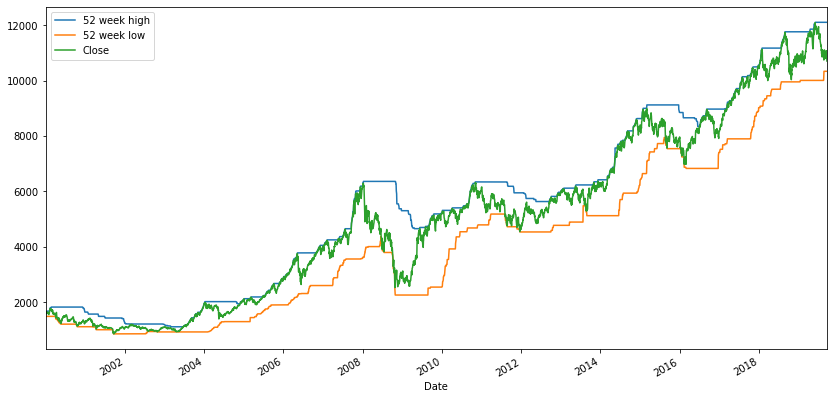

In [88]:
nifty[["52 week high", "52 week low", "Close"]].plot()
# nifty[["High"]].plot()

In [89]:
highs = (nifty["52 week high"] == nifty.High).value_counts()
print("Fraction of times market is at highs:", highs[True]/(highs[True] + highs[False]))
lows = (nifty["52 week low"] == nifty.Low).value_counts()
print("Fraction of times market is at lows:", lows[True]/(lows[True] + lows[False]))

Fraction of times market is at highs: 0.11054456455231491
Fraction of times market is at lows: 0.016724454415663878


In [170]:
class Parameters:
    def __init__(self, **kwds):
        self.__dict__.update(kwds)
params = Parameters(bear_delta=5, bear_percent=4, bear_ndays=100)

In [91]:
# Variables almost remaining constants
debt_rate = 0.074 # percent

In [173]:
# DebtCorpus with both a deposit() and a withdraw() function 
class DebtCorpus: 
    def __init__(self): 
        self.balance = 0
        self.date = datetime(1990, 1, 1)

    def Check(self, date):
        if (date < self.date):
            print("Date cannot be less than last account operation date")
            return False
        return True
  
    def Deposit(self, date, amount):
        if (self.Check(date) == False):
            return False
        delta = (date - self.date).days / 365.25
        self.balance = amount + self.balance * pow(1 + debt_rate, delta)
        self.date = date
        return True
  
    def Withdraw(self, date, amount): 
        if (self.Check(date) == False):
            return False
        delta = (date - self.date).days / 365.25
        self.balance = self.balance * pow(1 + debt_rate, delta)
        self.date = date
        fulfilled = min(self.balance, amount)
        if self.balance <= amount:
            print('Balance is lesser than requested', self.balance, amount)
        self.balance -= fulfilled 
        return fulfilled
  
    def Get(self, date):
        delta = (date - self.date).days / 365.25
        self.balance = self.balance * pow(1 + debt_rate, delta)
        self.date = date
        return self.balance 

In [161]:
# debt = DebtCorpus()
# print(debt.Deposit(datetime(2000, 1, 1), 100))
# print(debt.Withdraw(datetime(2010, 1, 1), 100))
# debt.Get(datetime(2020, 1, 1))

True
100


212.77761431538931

In [176]:
def EvaluateStrategy(df, params, pa = 100):
    naive_sips, curr_year = [], 0
    equity_investments = []
    debt_corpus = DebtCorpus()
    total_invested = 0
    min_chkpts = []
    bear_delta = params.bear_delta
    bear_percent = params.bear_percent
    nifty["bear_ndays"] = pd.Series.rolling(nifty.Low, window=params.bear_ndays, min_periods=1).min()
    for ind in df.index:
        if (naive_sips == [] or curr_year < ind.year):
            total_invested += pa
            naive_sips.append((ind, df.Close[0], pa))
            debt_corpus.Deposit(ind, pa)
            curr_year = ind.year
        if (df["bear_ndays"][ind] == df.Low[ind]):
            if (min_chkpts == []):
                min_chkpts = [ind]
            if (df.Close[ind] < (1 - bear_percent/100.0) * df.Close[min_chkpts[-1]]):
                min_chkpts.append(ind)
                if (len(min_chkpts)%2 == 0):
                    bear_delta = bear_delta * 2
                # Make investment
                amount = debt_corpus.Withdraw(ind, bear_delta)
                if (amount>0):
                    equity_investments.append((df.Close[ind], amount))
                    print (ind, df.Close[ind], amount, (1 - bear_percent/100.0))
    print("total_invested", total_invested)
    # Calculate the final profits
    index_close = df.Close.iloc[-1]
    equity_amount, equity_invested = 0, 0
    for i in equity_investments:
        equity_invested += i[1]
        equity_amount += i[1] * index_close / i[0]
    print('equity_amount:', equity_amount)
    print('equity_invested:', equity_invested)
    print("Equity returns:", equity_amount/equity_invested)
    debt_amount = debt_corpus.Get(df.index[-1])
    print('debt_amount:', debt_amount)
    overall_amount = debt_amount + equity_amount
    print("Overall returns:", overall_amount/total_invested)
    sip_amount = 0
    for i in naive_sips:
        print(i[2], index_close, i[1])
        sip_amount += i[2] * index_close / i[1]
    print("Naive SIP returns:", sip_amount / total_invested)
    # CAGR = [ (Ending value/Beginning Value)^(1/N) ] - 1

In [178]:
EvaluateStrategy(nifty, params)

2000-04-04 00:00:00 1428.1 10 0.96
2000-04-25 00:00:00 1359.45 10 0.96
2000-05-15 00:00:00 1299.25 20 0.96
2000-05-23 00:00:00 1224.4 20 0.96
2000-10-17 00:00:00 1158.05 40 0.96
2001-04-10 00:00:00 1103.05 40 0.96
Balance is lesser than requested 65.96764728036544 80
2001-04-12 00:00:00 1024.9 65.96764728036544 0.96
Balance is lesser than requested 0.0 80
Balance is lesser than requested 0.0 160
Balance is lesser than requested 0.0 160
total_invested 2000
equity_amount: 1940.2998688468788
equity_invested: 205.96764728036544
Equity returns: 9.420410896890623
debt_amount: 3717.814819874003
Overall returns: 2.8290573443604408
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 10704.8 1592.2
100 1070